In [ ]:
# default_exp tokenization

# Tokenization

> Tokenization and SMILES utils


In [1]:
#hide
%load_ext autoreload
%autoreload 2

In [2]:
#hide
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

# use IPythonConsole for pretty drawings
from rdkit.Chem.Draw import IPythonConsole

In [3]:
#export
import collections
import logging
import os
import re
import numpy as np
from rdkit import Chem

import pkg_resources

from typing import List

from transformers import BertTokenizer

## Reaction SMILES tokenizer

We use the same tokenizer as the one used for http://rxnmapper.ai.

It is an instance of [Hugginface Transformers](https://github.com/huggingface/transformers) BertTokenizer.

In [26]:
#export
SMI_REGEX_PATTERN =  r"(\%\([0-9]{3}\)|\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\||\(|\)|\.|=|#|-|\+|\\|\/|:|~|@|\?|>>?|\*|\$|\%[0-9]{2}|[0-9])"

def get_default_tokenizer():
    default_vocab_path = (
        pkg_resources.resource_filename(
                    "rxnfp",
                    "models/transformers/bert_ft_10k_25s/vocab.txt"
                )
    )
    return SmilesTokenizer(default_vocab_path, do_lower_case=False)


class SmilesTokenizer(BertTokenizer):
    """
    Constructs a SmilesBertTokenizer.
    Adapted from https://github.com/huggingface/transformers
    and https://github.com/rxn4chemistry/rxnfp.
    
    Args:
        vocabulary_file: path to a token per line vocabulary file.
    """

    def __init__(
        self,
        vocab_file: str,
        unk_token: str = "[UNK]",
        sep_token: str = "[SEP]",
        pad_token: str = "[PAD]",
        cls_token: str = "[CLS]",
        mask_token: str = "[MASK]",
        do_lower_case=False,
        **kwargs,
    ) -> None:
        """Constructs an SmilesTokenizer.
        Args:
            vocabulary_file: vocabulary file containing tokens.
            unk_token: unknown token. Defaults to "[UNK]".
            sep_token: separator token. Defaults to "[SEP]".
            pad_token: pad token. Defaults to "[PAD]".
            cls_token: cls token. Defaults to "[CLS]".
            mask_token: mask token. Defaults to "[MASK]".
        """
        super().__init__(
            vocab_file=vocab_file,
            unk_token=unk_token,
            sep_token=sep_token,
            pad_token=pad_token,
            cls_token=cls_token,
            mask_token=mask_token,
            do_lower_case=do_lower_case,
            **kwargs,
        )
        # define tokenization utilities
        self.tokenizer = RegexTokenizer()

    @property
    def vocab_list(self) -> List[str]:
        """List vocabulary tokens.
        Returns:
            a list of vocabulary tokens.
        """
        return list(self.vocab.keys())

    def _tokenize(self, text: str) -> List[str]:
        """Tokenize a text representing an enzymatic reaction with AA sequence information.
        Args:
            text: text to tokenize.
        Returns:
            extracted tokens.
        """
        return self.tokenizer.tokenize(text)


class RegexTokenizer:
    """Run regex tokenization"""

    def __init__(self, regex_pattern: str=SMI_REGEX_PATTERN) -> None:
        """Constructs a RegexTokenizer.
        Args:
            regex_pattern: regex pattern used for tokenization.
            suffix: optional suffix for the tokens. Defaults to "".
        """
        self.regex_pattern = regex_pattern
        self.regex = re.compile(self.regex_pattern)

    def tokenize(self, text: str) -> List[str]:
        """Regex tokenization.
        Args:
            text: text to tokenize.
        Returns:
            extracted tokens separated by spaces.
        """
        tokens = [f"{token}" for token in self.regex.findall(text)]
        return tokens
    

## Smiles Utils 

In [27]:
#export
class NotCanonicalizableSmilesException(ValueError):
    pass


def canonicalize_smi(smi, remove_atom_mapping=False):
    r"""
    Canonicalize SMILES
    """
    mol = Chem.MolFromSmiles(smi)
    if not mol:
        raise NotCanonicalizableSmilesException("Molecule not canonicalizable")
    if remove_atom_mapping:
        for atom in mol.GetAtoms():
            if atom.HasProp("molAtomMapNumber"):
                atom.ClearProp("molAtomMapNumber")
    return Chem.MolToSmiles(mol)


def process_reaction(rxn):
    """
    Process and canonicalize reaction SMILES 
    """
    reactants, reagents, products = rxn.split(">")
    try:
        precursors = [canonicalize_smi(r, True) for r in reactants.split(".")]
        if len(reagents) > 0:
            precursors += [
                canonicalize_smi(r, True) for r in reagents.split(".")
            ]
        products = [canonicalize_smi(p, True) for p in products.split(".")]
    except NotCanonicalizableSmilesException:
        return ""

    joined_precursors = ".".join(sorted(precursors))
    joined_products = ".".join(sorted(products))
    return f"{joined_precursors}>>{joined_products}"

# Examples

`process_reaction` removes atom-mapping, canonicalizes the molecules and combines reactant and reactions

In [28]:
atom_mapped_rxn = 'F[c:5]1[n:6][cH:7][cH:8][cH:9][c:10]1[F:11].[CH3:1][CH:2]([CH3:3])[SH:4]>CN(C)C=O.O=C([O-])[O-].[K+].[K+]>[CH3:1][CH:2]([CH3:3])[S:4][c:5]1[n:6][cH:7][cH:8][cH:9][c:10]1[F:11]'
canonical_rxn = "CC(C)S.CN(C)C=O.Fc1cccnc1F.O=C([O-])[O-].[K+].[K+]>>CC(C)Sc1ncccc1F"
tokenized_rxn = 'C C ( C ) S . C N ( C ) C = O . F c 1 c c c n c 1 F . O = C ( [O-] ) [O-] . [K+] . [K+] >> C C ( C ) S c 1 n c c c c 1 F'

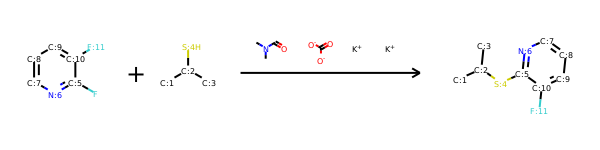

In [29]:
AllChem.ReactionFromSmarts(atom_mapped_rxn, useSmiles=True)

In [30]:
assert canonical_rxn == process_reaction(atom_mapped_rxn)

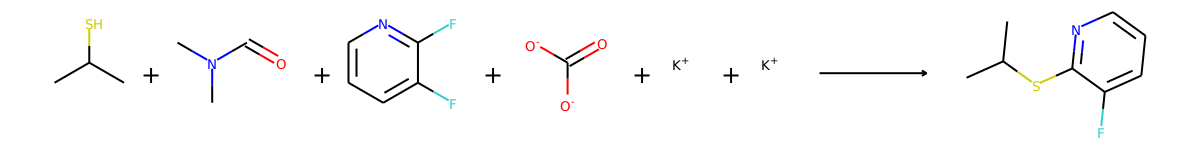

In [31]:
AllChem.ReactionFromSmarts(canonical_rxn, useSmiles=True)

`SmilesTokenizer` splits the reaction SMILES into tokens.

In [32]:
tokenizer = get_default_tokenizer()
assert isinstance(tokenizer, SmilesTokenizer)
basic_tokenizer = RegexTokenizer()

In [33]:
assert tokenized_rxn == ' '.join(basic_tokenizer.tokenize(canonical_rxn))